Curve Fitting: Fitting a LRC resonance curve to data using `lmfit`
==================================================================

Introduction
------------

In experimental physics we often have a set of data and a model of the data, 
in the form of
some function. Parameters of the model can be obtained by matching the model
to the data. In modern physics this is done by adjusting the parameters of the model
to minimise some statistic. This usually requires a computer program, since 
the dependence of the model on its parameters is seldom linear, or solvable.

This process is usually referred to as "curve-fitting", and the statistic
to be determined is a "goodness of fit" value. (This is equivalent, 
under some conditions, to maximising the likelihood of the model).


In the series $LRC$ circuit, the response $V_R/V_0$ may be  measured as a function of frequency $f$, where $V_R$ is the amplitude
of the voltage across the resistor and $V_0$ is the amplitude of the voltage across the whole circuit (i.e. the applied voltage).

The theory of the driven oscillator tells us that the expected response is
$$
\left|\frac{V_R}{V_0}\right|=\frac{R}{R_T}\frac{1}{\sqrt{1+Q^2\left(\frac{f}{f_0}-\frac{f_0}{f}\right)^2}}
$$
Here, $R$ is the value of the resistor, $R_T=R+R_X$ is the total resistance in the circuit ($R_X$ is mainly the resistance of the inductor at frequency $f$), $f_0$ is the resonance frequency and Q is the quality factor of the circuit.

The value of the inductance can be obtained from
$$
L=\frac{R_TQ}{2\pi f_0}
$$

What is measured is $V_0$ and its associated uncertainty $\delta V$, and at each frequency the voltage $V_R$ and its uncertainty $u$.

We fit the response function to the data to obtain $R_T$, $Q$ and $f_0$; then we can compute $L$ and its uncertainty.

The uncertainty in $|V_R/V|$ depends on the uncertainties of both quantities. Propagation of uncertainties yields
$$
u_{\text{tot}}=\frac{1}{V_0}\sqrt{u^2+\delta V^2\frac{V_R^2}{V_0^2}}=\frac{1}{V_0}\sqrt{u^2+\epsilon^2 V_R^2}
$$

Note that $\delta V/V_0$ is a constant, say $\epsilon$.

The fitting program
-------------------

Fitting a curve to data is usually done by adjusting a set of parameters that characterise the curve in order 
to minimise a goodness of fit variable. A typical goodness of fit variable is the "chi square" value,
$$
\chi^2=\sum_{i=1}^N\frac{(y_i-f(x_i;p))^2}{u_i^2}
$$
where $i$ runs over the data points, $y_i$ is the value of the data at $x_i$ and $f(x_i;p)$ is the
curve value which depends on $x_i$ and a set of parameters $\{p\}$. The data points are weighted by the
uncertainty $u_i$. You will notice that the sum of the squares of the residuals $y_i-f(x_i;p)$ is minimised;
the procedure is known as a weighted least-squares fit.  Most functions are not linear in the parameters.
No simple solution of the problem is known and the parameters must be adjusted iteratively in order to converge to a minimum.
This minimum might not be a global minimum, so a good set of starting parameters helps; a hand-drawn graph might help
in obtaining these. The scheme we will use in order to minimise the chi squared is the Levenberg-Marquard algorithm.

A detailed explanation of what this does and how to obtain and interpret the uncertainties is beyond the scope of these
notes. You are directed to a reference you should get to know, Numerical Recipes, *Press, Teukolsky, Vetterling, Flannery*,
Cambridge University Press.

In this notebook, we use `matplotlib` to plot and `lmfit` to do the fit. For further analysis we use
`corner` and `emcee`. The libraries `lmfit`, `corner` and `emcee` will probably need to be installed. For example, if you are using the Anaconda python distribution:
```
conda install -c conda-forge lmfit
conda install -c conda-forge corner
conda install -c conda-forge emcee
```

The Code
--------

Start with the imports of the libraries we use.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit

For convenience, we enter the data into the code

In [25]:
#  data from LRC circuit measurement: [frequency, amplitude, uncertainty]
data=np.array([
    [ 2653, 1.08, 0.01 ],
    [ 2968, 1.28, 0.02 ],
    [ 3633, 1.92, 0.02 ],
    [ 4169, 2.86, 0.02 ],
    [ 4475, 3.70, 0.02 ],
    [ 4768, 4.90, 0.05 ],
    [ 5002, 6.05, 0.05 ],
    [ 5277, 7.45, 0.05 ],
    [ 5561, 7.80, 0.2 ],
    [ 5765, 7.00, 0.05 ],
    [ 6117, 5.55, 0.05 ],
    [ 6391, 4.55, 0.05 ],
    [ 6696, 3.76, 0.02 ],
    [ 7189, 2.95, 0.02 ],
    [ 7916, 2.24, 0.02 ],
    [ 8779, 1.75, 0.02 ],
    [ 9681, 1.45, 0.02 ],
    [ 10284, 1.27, 0.02 ]
    ])
freq,vr,dvr=data.T

# uncertainty calculation
v0=10.0     # input to circuit
epsilon=0.05 # relative uncertainty in v0
uvr=np.sqrt(dvr*dvr+vr*vr*epsilon**2)/v0

Define the LRC resonance functions which are used in the various fit models.

In [26]:
# define function to be fitted, used in Model
def resonance(f,R0,f0,Q):
    R=214.0
    return (R/R0)/np.sqrt(1.0+Q**2*(f/f0-f0/f)**2)

#def function to be minimised, used in Minimize
def fcntomin(param, f, data, eps=None):
    R=214.0
    p=param.valuesdict()
    model=(R/p['R0'])/np.sqrt(1.0+p['Q']**2*(f/p['f0']-p['f0']/f)**2)
    if eps is None:
        return model-data
    else:
        return (model-data)/eps

# def function to be used in MC uncertainty analysis (the log likelihood)
def loglike(param, f, data, eps=None):
    #noise=param['noise']
    return -0.5*(np.sum(fcntomin(param,f,data,eps)**2)+np.log(2.0*np.pi*np.sum(eps*eps)))

Now we define some initial values for the fit parameters. `lmfit` defines a `Parameter` object to store these. We set initial values and minimum and maximum for each value. Setting the min and max helps in the later Monte Carlo analysis but is not really needed for the fit.

In [27]:
# the fit parameters: some starting values
param=lmfit.Parameters()
param.add('R0',value=400.0, min=200.0, max=500.0)
param.add('f0',value=4000.0,min=3000.0,max=10000.0)
param.add('Q',value=4.0,min=3.0, max=7.0)

# use these for inital plot
R0=400.0;f0=4000.0;Q=1.0
p=[R0,f0,Q]
name=["R","f0","Q"]

We will plot the starting position to show how well, or badly, our initial guess of the parameters worked. So we
define a set of points for plotting the function and keep a copy of the initial resonance curve.

In [28]:
# for theory plot we need some frequencies
freqs=np.linspace(2000.0,11000.0,100)
initialplot=resonance(freqs,*p)
#print(p)

Now we use the Levenberg-Marquardt routine from `lmfit` to do the fit. 

This is one way. Create a `Minimizer` object and use the `minimize` method to do the fit. 

In [29]:
# do fit, here with leastsq model
minner = lmfit.Minimizer(fcntomin, param, fcn_args=(freq, vr/v0),fcn_kws={'eps':uvr})
result = minner.minimize()

# calculate final result
final = vr/v0 + result.residual

# write error report
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 42
    # data points      = 18
    # variables        = 3
    chi-square         = 1.086
    reduced chi-square = 0.072
    Akaike info crit   = -44.538
    Bayesian info crit = -41.867
[[Variables]]
    R0:   273.420951 +/- 2.197094 (0.80%) (init= 400)
    f0:   5486.69190 +/- 5.592465 (0.10%) (init= 4000)
    Q:    4.53096271 +/- 0.047888 (1.06%) (init= 4)
[[Correlations]] (unreported correlations are <  0.100)
    C(R0, Q)                     = -0.914 


The goodness of fit is defined via the $\chi^2$ value (known as the chi squared). We can use this and the covariance matrix to estimate the uncertainties in the parameters. This procedure is described in Numerical Recipes. 

Note that in this case, there is a strong (anti-)correlation between the variables $R_T$ and $Q$. If we calculate $L$ using these,
we must use the full covariance matrix in calculating the uncertainty in $L$, rather than just the diagonal elements.
It makes quite a difference.

In [30]:
# calculate final chi square
minparam=result.params
cov=result.covar
p2=[minparam['R0'],minparam['f0'],minparam['Q']]
pmin=p2
print(p2)
ymin=(vr/v0-resonance(freq, *p2))/uvr
chisq=sum(ymin*ymin)

dof=len(freq)-len(p)
# chisq, sqrt(chisq/dof) agrees with gnuplot
print("Converged with chi squared ",chisq)
print("degrees of freedom, dof ", dof)
print( "RMS of residuals (i.e. sqrt(chisq/dof)) ", np.sqrt(chisq/dof))
print( "Reduced chisq (i.e. variance of residuals) ", chisq/dof)
print()

# uncertainties are calculated as per gnuplot, "fixing" the result
# for non unit values of the reduced chisq.
# values at min match gnuplot
print( "Fitted parameters at minimum, with 68% C.I.:")
for i,pmin in enumerate(p2):
    print( "%2i %10s %12f +/- %10f"%(i,name[i],pmin,np.sqrt(cov[i,i])))#*sqrt(chisq/dof))
print()

print( "Correlation matrix")
# correlation matrix close to gnuplot
print( "               ",end='')
for i in range(len(p)): print( "%-10s"%(name[i],),end='')
print()
for i in range(len(p2)):
    print( "%10s"%name[i],end='')
    for j in range(i+1):
        print( "%10f"%(cov[i,j]/np.sqrt(cov[i,i]*cov[j,j]),),end='')
    print()

ap2=np.array(p2)
partials=np.outer(ap2,ap2)

L=p2[0]*p2[2]/(2.0*np.pi*p2[1])
dL=L*np.sqrt(cov[0,0]/p2[0]**2+cov[1,1]/p2[1]**2+cov[2,2]/p2[2]**2)
dLfull=L*np.sqrt(np.sum(cov/partials))
print()
print( "L", L, "+/-", dL, "  (diagonal elements)")
print( "L", L, "+/-", dLfull, "  (full covariance matrix)"  )

[<Parameter 'R0', value=273.4209510854625 +/- 2.2, bounds=[200.0:500.0]>, <Parameter 'f0', value=5486.691903920913 +/- 5.59, bounds=[3000.0:10000.0]>, <Parameter 'Q', value=4.5309627110700275 +/- 0.0479, bounds=[3.0:7.0]>]
Converged with chi squared  1.086207449843219
degrees of freedom, dof  15
RMS of residuals (i.e. sqrt(chisq/dof))  0.2690981790899893
Reduced chisq (i.e. variance of residuals)  0.07241382998954794

Fitted parameters at minimum, with 68% C.I.:
 0          R   273.420951 +/-   2.197094
 1         f0  5486.691904 +/-   5.592465
 2          Q     4.530963 +/-   0.047889

Correlation matrix
               R         f0        Q         
         R  1.000000
        f0  0.023330  1.000000
         Q -0.914117  0.006075  1.000000

L 0.035936173844903684 +/- 0.0004785293412259425   (diagonal elements)
L 0.035936173844903684 +/- 0.00017068560140422637   (full covariance matrix)


Now we just have to plot the results. This is always a useful check to see if the fit "looks good".

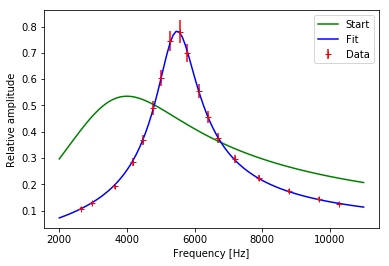

In [31]:
# Plot

# plot data
plt.errorbar(freq, vr/v0, yerr=uvr, fmt='r+', label="Data")
# plot fit
plt.plot(freqs, initialplot, 'g-', label="Start")
plt.plot(freqs, resonance(freqs,*p2), 'b-', label="Fit")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Relative amplitude")
#legend(("data","fit"))
plt.legend()
plt.show()

How do we interpret these results?

The fitted parameters are given with their standard uncertainties, assuming that the other parameters are fixed. These uncertainties
are only good estimates if the parameters are uncorrelated. In general, a more sophisticated approach is needed to evaluate reliable
uncertainties. But these are a good start.

The correlation matrix tells us how one parameter varies with another. The values are in $-1\le C\le 1$.
We see for instance that R and Q are strongly negatively correlated. Thus if R is increased, Q must decrease to compensate.
Care has to be used in using these uncertainties in propagation.

---

Monte Carlo methods for uncertainty analysis
============================================

The code `lmfit` has methods for calculating the *Bayesian posterior probability* for the distribution of the fit parameters. In other words, the full probability distribution of each fit parameter is calculated, from which uncertainty ranges may be calculated. This uses the Monte Carlo program `emcee`. A graphic visualisation of these is generated by `corner`.

In [35]:
# MC for parameters: use the log likelihood function.
mcmin = lmfit.Minimizer(loglike, minner.params, fcn_args=(freq, vr/v0),fcn_kws={'eps':uvr})
res = mcmin.emcee(burn=300, steps=1000, thin=5, params=minner.params, is_weighted=True)
print("done") # takes a while, needs some feedback.

done


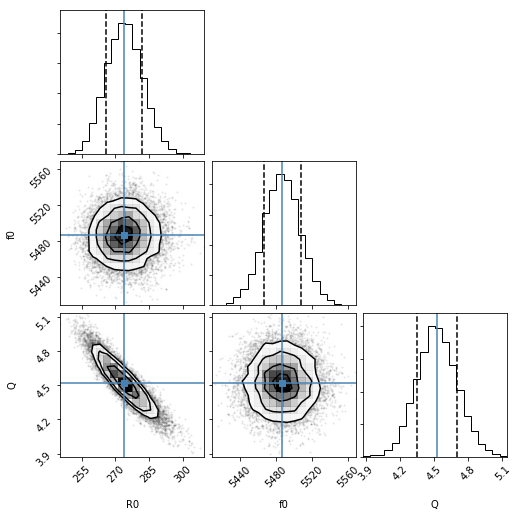

In [37]:
import corner
figure=corner.corner(res.flatchain, bins=20, quantiles=(0.16,0.84), 
                     labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [38]:
lmfit.report_fit(res.params)


[[Variables]]
    R0:   273.869686 +/- 8.093150 (2.96%) (init= 400)
    f0:   5486.71980 +/- 20.44064 (0.37%) (init= 4000)
    Q:    4.52238782 +/- 0.176984 (3.91%) (init= 4)
[[Correlations]] (unreported correlations are <  0.100)
    C(R0, Q)                     = -0.909 


In [42]:
# from lmfit docs ...
# find the maximum likelihood solution
p=minner.params
highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
mle_soln = res.chain[hp_loc]
for i, par in enumerate(p):
     p[par].value = mle_soln[i]

print("\nMaximum likelihood Estimation")
print('-----------------------------')
#print(p)
# Finally lets work out a 1 and 2-sigma error estimate for 't1'
quantiles = np.percentile(res.flatchain['R0'], [2.28, 15.9, 50, 84.2, 97.7])
print("Parameter ",p["R0"].name," = ",p['R0'].value)
print("1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))
quantiles = np.percentile(res.flatchain['f0'], [2.28, 15.9, 50, 84.2, 97.7])
print("Parameter ",p["f0"].name," = ",p['f0'].value)
print("1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))
quantiles = np.percentile(res.flatchain['Q'], [2.28, 15.9, 50, 84.2, 97.7])
print("Parameter ",p["Q"].name," = ",p['Q'].value)
print("1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))



Maximum likelihood Estimation
-----------------------------
Parameter  R0  =  273.1394954818662
1 sigma spread 8.096900166644588
2 sigma spread 16.22327450078879
Parameter  f0  =  5486.791506129243
1 sigma spread 20.44903864647449
2 sigma spread 41.653211935892614
Parameter  Q  =  4.535504569972398
1 sigma spread 0.17716217727728312
2 sigma spread 0.3542645017529975


---

Alternate fits
==============

Now do the fit using the  `lmfit` Model class.

[[Model]]
    Model(resonance)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 18
    # variables        = 3
    chi-square         = 1.086
    reduced chi-square = 0.072
    Akaike info crit   = -44.538
    Bayesian info crit = -41.867
[[Variables]]
    R0:   273.420927 +/- 2.197093 (0.80%) (init= 273.1395)
    f0:   5486.69196 +/- 5.592484 (0.10%) (init= 5486.792)
    Q:    4.53096329 +/- 0.047888 (1.06%) (init= 4.535505)
[[Correlations]] (unreported correlations are <  0.100)
    C(R0, Q)                     = -0.914 



(<matplotlib.figure.Figure at 0x1a14a8f438>,
 <matplotlib.gridspec.GridSpec at 0x1a14a8f978>)

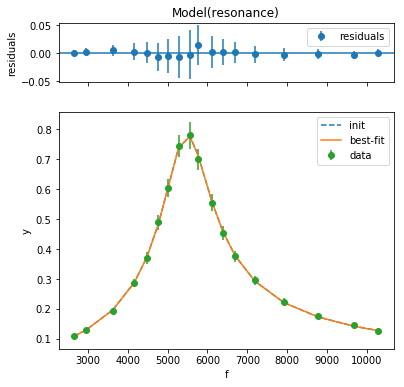

In [43]:
model=lmfit.Model(resonance)
w=1.0/uvr 
result=model.fit(vr/v0,f=freq, params=param, weights=w)
print(result.fit_report())
result.plot()

---

References
----------

Numerical Recipes, *Press, Teukolsky, Vetterling, Flannery*, Cambridge University Press.